In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

### Wczytywanie danych

In [ ]:
df_apa = pd.read_csv("apartments.csv")
df_wine = pd.read_csv("winequality-white.csv", sep = None)

In [ ]:
df_apa = df_apa.drop(['Unnamed: 0'], axis = 1)

df_apa - ramka z danymi o cenach mieszkań w Warszawie \\
df_wine - ramka danych opisująca wina różnych gatunków, celem jest wskazanie jakości (można potraktować jako regresję)

---



In [ ]:
df_apa.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897,1953,25,3,1,Srodmiescie
1,1818,1992,143,9,5,Bielany
2,3643,1937,56,1,2,Praga
3,3517,1995,93,7,3,Ochota
4,3013,1992,144,6,5,Mokotow


In [ ]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### EDA

In [ ]:
df_apa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           1000 non-null   int64 
 1   construction.year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no.rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


In [ ]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


W żadnej z ramek nie wystepują wartości null.





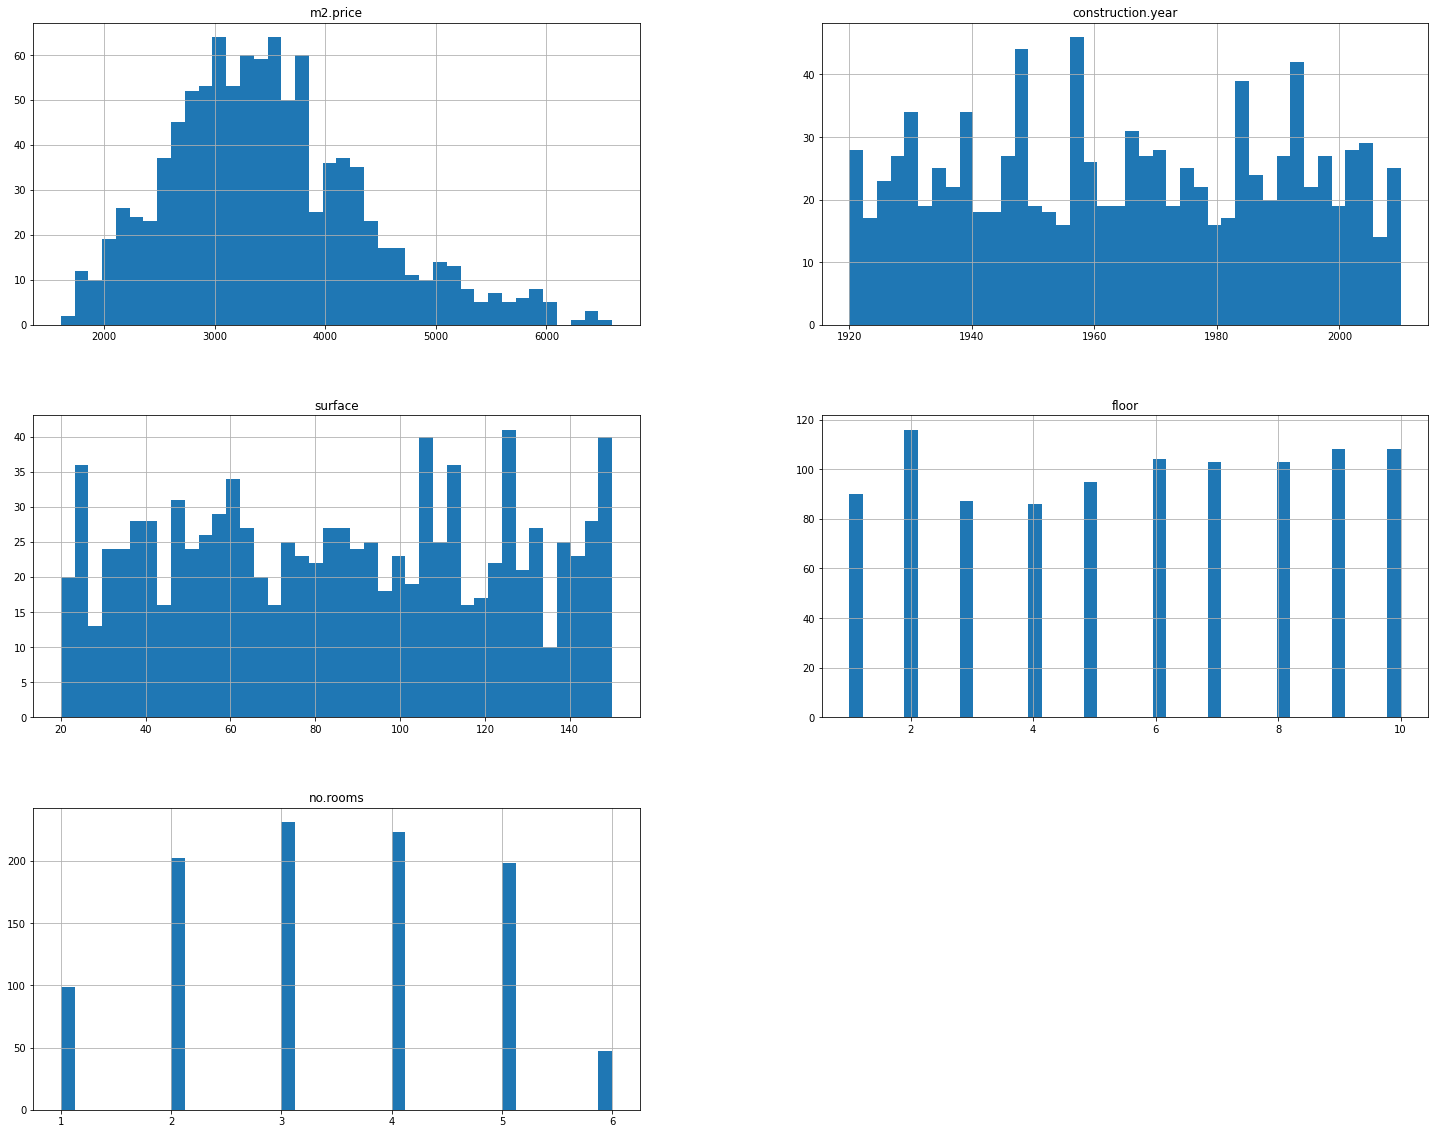

In [ ]:
df_apa.hist(bins = 40, figsize = (25,20))
plt.show()

Najbardziej zbliżony do rozkładu normalnego jest wykres ceny za metr kwadratowy- jest on jednak niejako 'przechylony' w lewo.

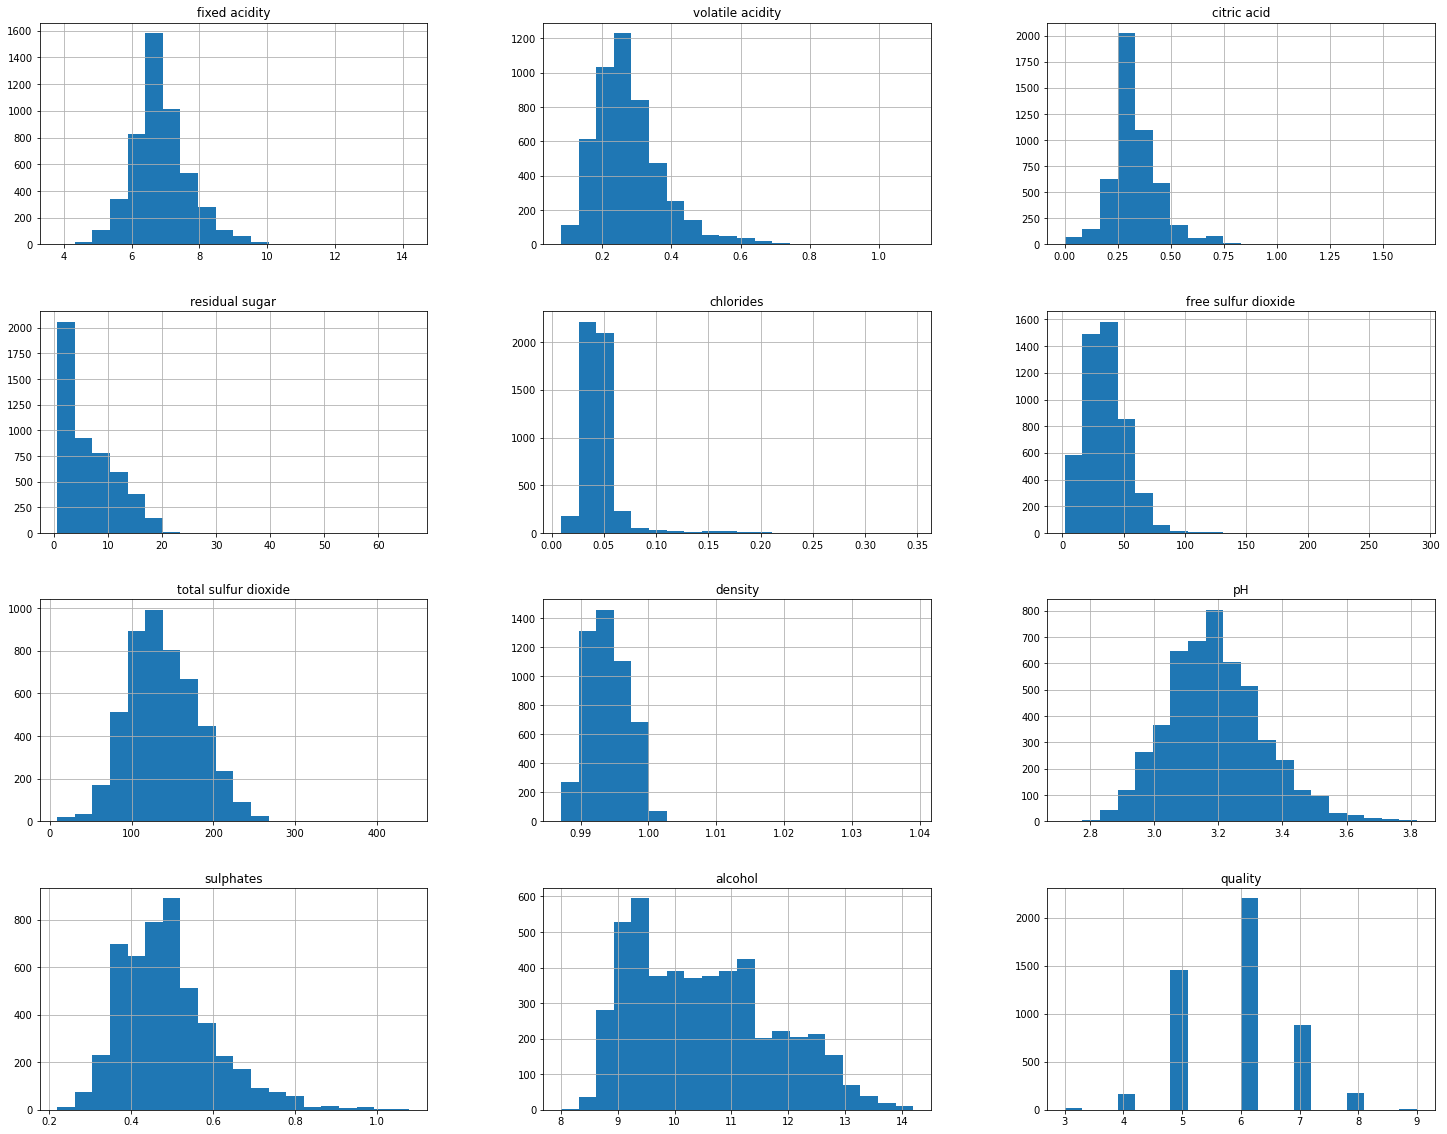

In [ ]:
df_wine.hist(bins = 20, figsize = (25,20))
plt.show()

Jak widać tutaj większość rozkładów ma 'grube ogony'.

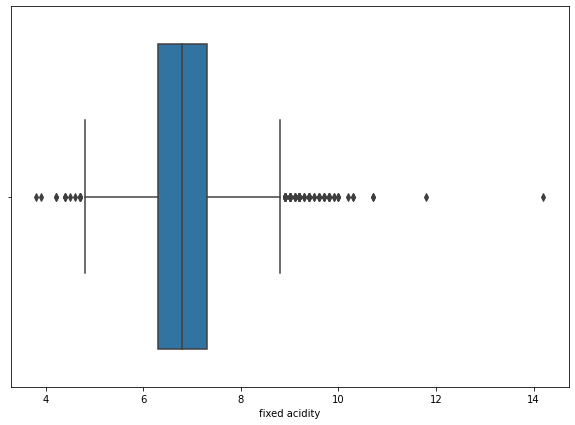

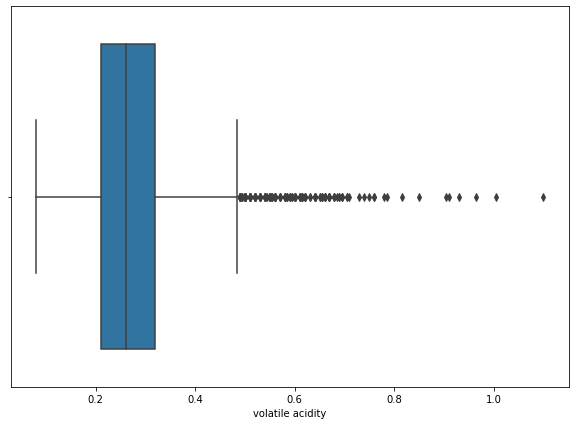

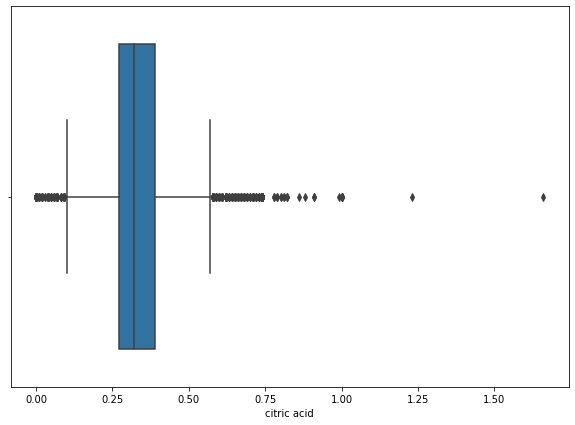

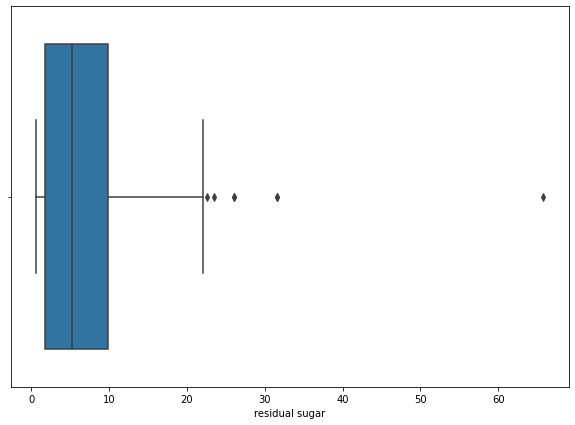

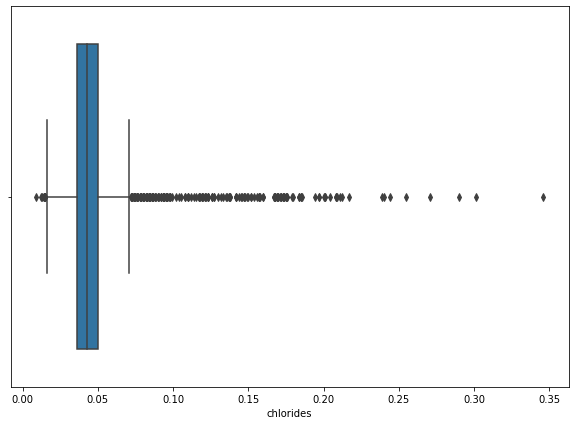

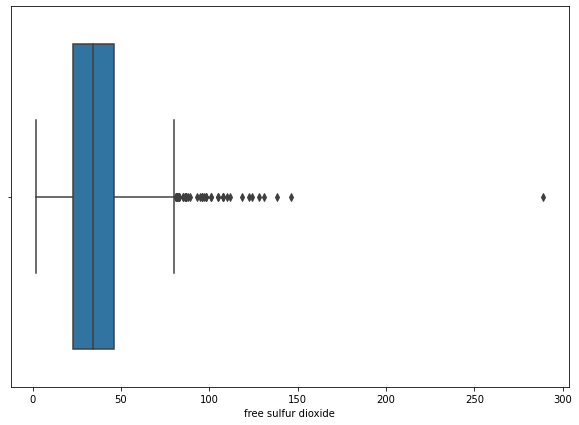

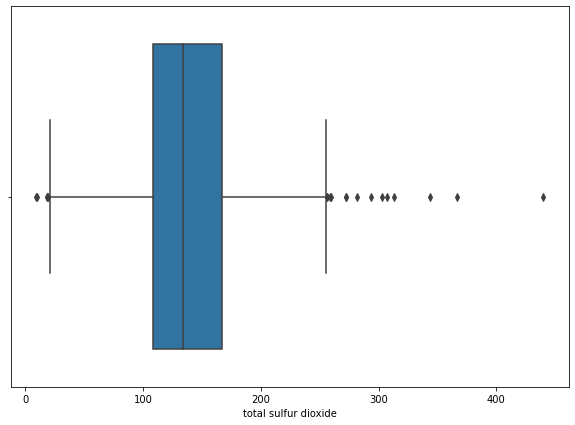

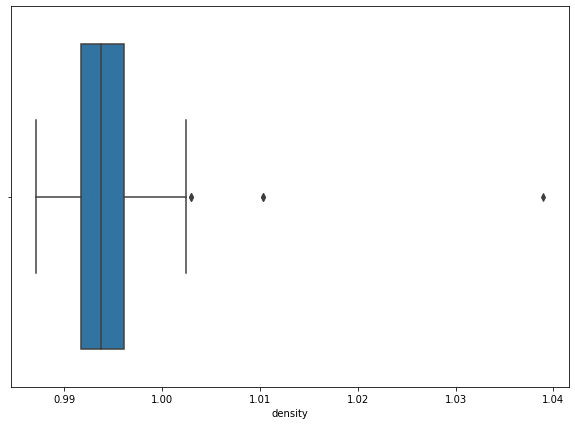

In [ ]:
for i in range(8):
  sns.boxplot(df_wine.iloc[:,i])
  plt.show()

Po dokładniejszym przeanalizowaniu widać, że większość cech ma pojedyncze wartości odstające, reszta wartości jest dość "zbita". Warto więc spróbować "pozbyć się" odstających wartości. 

In [ ]:
maxindexes = set([])

In [ ]:
for i in range(8):
  maxindexes.add(df_wine.iloc[:,i].idxmax())

In [ ]:
df_wine.drop(df_wine.index[list(maxindexes)], inplace = True)

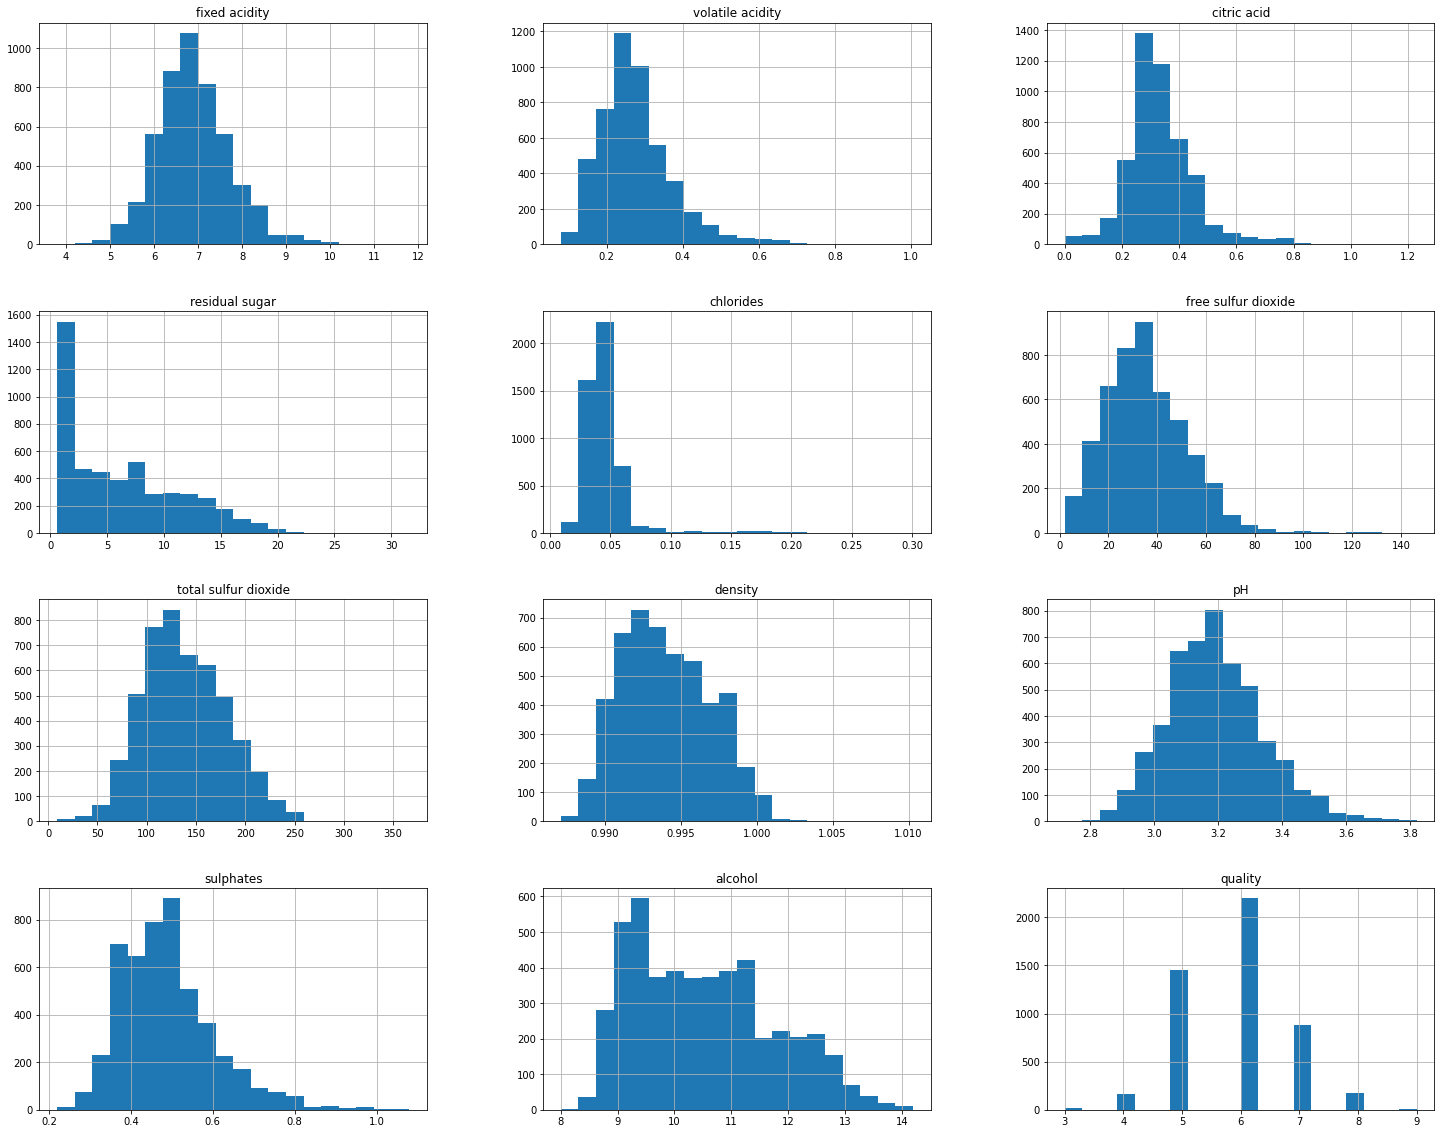

In [ ]:
df_wine.hist(bins = 20, figsize = (25,20))
plt.show()

Jak widać wykresy nieco się poprawiły.

Sprawdźmy jeszcze macierze korelacji.



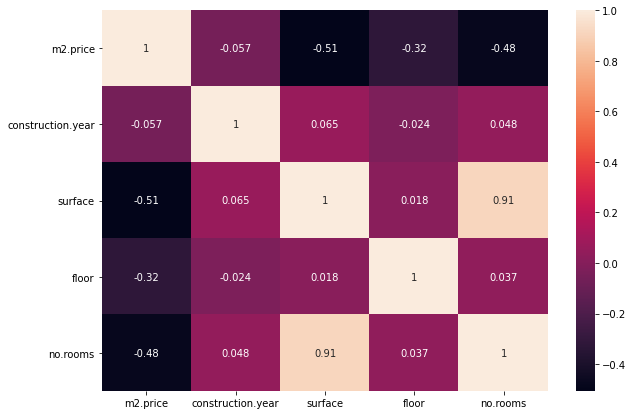

In [ ]:
sns.heatmap(df_apa.corr(), annot=True)
matplotlib.rcParams['figure.figsize'] = [10,7]
plt.show()

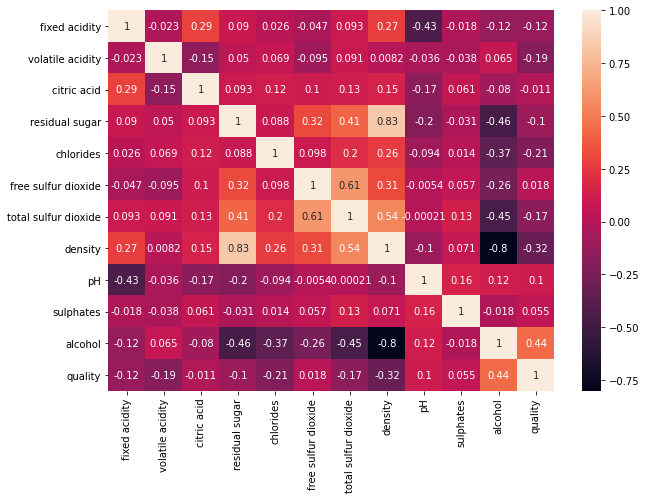

In [ ]:
sns.heatmap(df_wine.corr(), annot=True)
matplotlib.rcParams['figure.figsize'] = [10,7]
plt.show()

Najbardziej podejrzane wydaje się odwrotne skorelowanie zmiennych 'alcohol' i 'density' w ramce danych o winach. Mimo wszystko jednak zdecydowałem się pozostawić wszystkie cechy w obydwu ramkach.

### Modelowanie

Ponieważ SVM jest stosowany do zadań klasyfikacji (a w szczególności klasyikacji binarnej), 
to do zadania regresji wykorzystamy SVR z pakietu sklearn (szczególnie, że nasze ramki danych nie są przesadnie duże).

In [ ]:
X_apa = df_apa.drop(['m2.price'], axis = 1)
y_apa = df_apa['m2.price']
X_wine = df_wine.drop(['quality'], axis = 1)
y_wine = df_wine['quality']

In [ ]:
X_apa_train, X_apa_test, y_apa_train, y_apa_test = train_test_split(X_apa,y_apa, test_size = 0.25)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine,y_wine, test_size = 0.25)

Prztestujemy narazie 2 różne rozwiązania: model przetrenujemy raz na zwykłych danych, a raz na danych przeskalowanych za pomocą StandardScaler.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


In [ ]:
categorical_columns = ['district']
numerical_columns = ['construction.year','surface', 'floor', 'no.rooms']
ct = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_columns),
                  ('num', StandardScaler(), numerical_columns)]
)

In [ ]:
pipe_scale = Pipeline(steps = [('ct',ct),
                         ('regression',SVR())])

In [ ]:
transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_columns)
                  ],remainder='passthrough'
)

In [ ]:
pipe = Pipeline(steps = [('pre', transformer),
                         ('regression',SVR())])

In [ ]:
scaler = StandardScaler()
scaled_wine = scaler.fit_transform(X_wine_train)

In [ ]:
svr = SVR()

In [ ]:
def train_test_model(X_train,y_train,X_test,y_test,model):
  model.fit(X_train,y_train)
  print(mean_squared_error(y_test, model.predict(X_test)))

In [ ]:
#Przeskalowane dane apartments
train_test_model(X_apa_train,y_apa_train,X_apa_test,y_apa_test, pipe_scale)

834263.8706280469


In [ ]:
#Dane apartments
train_test_model(X_apa_train,y_apa_train,X_apa_test,y_apa_test, pipe)

878358.3418160722


In [ ]:
#Przeskalowane dane o winie
train_test_model(scaled_wine,y_wine_train,X_wine_test,y_wine_test, svr)

0.9273768170618074


In [ ]:
#Dane o winie
train_test_model(X_wine_train,y_wine_train,X_wine_test,y_wine_test, svr)

0.6798741749072805


Jak widać, wyniki są niejednoznaczne- w jednym przypadku skalowanie polepszyło wynik, w innym- pogorszyło

Strojenie hiperparametrów:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import poisson,expon,norm

In [ ]:
params= {'C': expon(0.05),
         'gamma': ['auto','scale'],
         'degree': norm()}
random = RandomizedSearchCV(estimator=svr, param_distributions=params, cv = 5, n_jobs=-1, scoring = 'neg_mean_squared_error')

In [ ]:
random.fit(X_wine_train,y_wine_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f769f21b490>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f769e50fa10>,
                                        'gamma': ['auto', 'scale']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

In [ ]:
random.best_params_

{'C': 4.085587826459984, 'degree': 0.6434242266467836, 'gamma': 'scale'}

In [ ]:
abs(random.score(X_wine_test,y_wine_test))

0.6165179987916345

In [ ]:
X_apa_train = pd.get_dummies(data = X_apa_train, columns = ['district'])
X_apa_test = pd.get_dummies(data = X_apa_test, columns = ['district'])

In [ ]:
random.fit(X_apa_train,y_apa_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f769f21b490>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f769e50fa10>,
                                        'gamma': ['auto', 'scale']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

In [ ]:
random.best_params_

{'C': 1.1338255620143143, 'degree': 0.04426508148205732, 'gamma': 'auto'}

In [ ]:
abs(random.score(X_apa_test,y_apa_test))

877664.0798366463

Jak widzimy, random search wpłynął pozytywnie na wyniki(biorąc pod uwagę dane nieprzeskalowane).